In [1]:
import pandas as pd
import numpy as np
import re
import json
import ollama
import chromadb
import time
from openai import OpenAI
import os

# GPT API

In [12]:
gpt = OpenAI(
    # 将这里换成你在便携AI聚合API后台生成的令牌
    api_key="sk-cklA0a53iPtuuL6SqFcn78ElW38iPQ8agPmj1ps2DRiyEMXY",
    # 这里将官方的接口访问地址替换成便携AI聚合API的入口地址
    base_url="https://api.bianxie.ai/v1"
)

completion = gpt.chat.completions.create(
    model="gpt-4o-mini-2024-07-18",
    messages=[
        {
            "role": "user",
            "content": "Who are you",
        }
    ]
)
print(completion.choices[0].message.content)

APITimeoutError: Request timed out.

# qwen API

In [2]:
qwen = OpenAI(
    # 若没有配置环境变量，请用百炼API Key将下行替换为：api_key="sk-xxx",
    api_key="sk-bbf9f24ff4194920a43e15749a2dad29",
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1",
)
# 模型列表：https://help.aliyun.com/zh/model-studio/getting-started/models

completion = qwen.chat.completions.create(
    model="qwen2.5-72b-instruct", 
    messages=[
        {'role': 'system', 'content': 'You are a helpful assistant.'},
        {'role': 'user', 'content': 'Are you qwen2.5-72b?'},],
    )

# output_test = completion.choices[0].message.content
# print(output_test)

In [5]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.dropna(inplace=True)

    def interpret_brightness(brightness_level):
        if 0 <= brightness_level <= 100:
            return "dark"
        elif 100 < brightness_level <= 150:
            return "dim"
        elif 150 < brightness_level <= 500:
            return "normal lighting"
        elif 500 < brightness_level <= 1000:
            return "very bright"
        else:
            return "dark"

    def generate_description(row):
        brightness_description = interpret_brightness(row['BrightnessLevel'])
        # return f"{row['UserActivity']} in the {row['Location']} when it is {brightness_description} at {row['Timestamp']}."
        pd.set_option('display.max_colwidth', None)
        description = f"{row['UserActivity']} in the {row['Location']} at {row['Timestamp']} when the environment is {brightness_description}."
        return description

    df['Description'] = df.apply(generate_description, axis=1)

    # only use the lastest state
    df_latest = df.iloc[-1:]
    df_latest = df_latest['Description']
    df_latest = df_latest.to_string(index=False)
    # print(df_latest)

    # use last 10 states
    df_history = df.iloc[-10:]
    df_history = df_history['Description']
    df_history = df_history.to_string(index=False)
    # print(df_history)

    return df_latest, df_history

def extract_json_from_response(response_text):
    """
    Extracts the JSON object from the assistant's response.
    """
    import json

    brace_count = 0
    json_start = None

    for i, char in enumerate(response_text):
        if char == '{':
            if brace_count == 0:
                json_start = i
            brace_count += 1
        elif char == '}':
            brace_count -= 1
            if brace_count == 0 and json_start is not None:
                json_str = response_text[json_start:i+1]
                try:
                    # Try to parse the extracted string
                    json.loads(json_str)
                    return json_str
                except json.JSONDecodeError:
                    pass  # Continue searching for valid JSON
    raise ValueError("No valid JSON object found in the assistant's response.")


    
def LLM2(knowledge_base, df_latest, collection, df_history, light_status):

    # user_query = f"""
    # There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    # Now the light status is {light_status}, recent user behaviors are: {df_history}, tell me Which lights should be turned on/off while the user is {df_latest}? "
    # """ 

# no context aware
    user_query = f"""
    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {light_status}, tell me Which lights should be turned on/off while the user is {df_latest}? "
    """ 


    print("User Query:")
    print(user_query)

    query_response = ollama.embeddings(
        prompt=user_query,
        model="mxbai-embed-large"
    )

    results = collection.query(
        query_embeddings=[query_response["embedding"]],
        n_results= 30  # Retrieve top 10 relevant documents
    )

    retrieved_documents = results['documents'][0]  
    data = ' '.join(retrieved_documents)
    print("Retrieved Data:")
    print(data)

#     final_prompt = f"""
# You are an AI smart home assistant.

# Your goal is to determine the most suitable lighting configuration based on the user's current activity, recent behavioral patterns, and the user's established preferences.

# **Context:**
# - There are 5 lights in the living room:
#   - Light1: Main ceiling light with warm/neutral/cool settings.
#   - Light2: Ambient light above the TV.
#   - Light3: A table lamp.
#   - Light4: A thin curtain on a large French window.
#   - Light5: Main dining room light adjacent to the living room.

# **Current Conditions:**
# - Current light status: {light_status}
# - Current user activity: {df_latest}
# - Recent user behaviors: {df_history}

# **Important Consideration:**
# Recent user behaviors may include brief, transitional activities (e.g., quickly sitting between periods of eating). These short-duration actions should not cause permanent adjustments to the user's preferences. Focus on identifying stable activities that truly reflect the user’s intent, rather than transient states.

# **Knowledge Base (User Preferences):**
# {data}

# **Instructions:**
# 1. Analyze the user's current activity ({df_latest}) and recent behaviors ({df_history}) to distinguish stable activities from short-lived transitions.
# 2. Refer to the knowledge base ({data}) to understand and honor the user’s lighting preferences for the identified stable activity.
# 3. Determine which lights to turn on/off or curtains to open/close to match the user’s established preferences and current needs.
# 4. Provide the final lighting configuration in the specified JSON format.

# **JSON Output Format:**
# ```json
# {{
#     "description": "{df_latest}",
#     "light1": "on/off",
#     "light2": "on/off",
#     "light3": "on/off",
#     "light4": "open/close",
#     "light5": "on/off"
# }}
#     """


# no context aware
    final_prompt = f"""
You are an AI smart home assistant.

Your goal is to determine the most suitable lighting configuration based on the user's current activity, recent behavioral patterns, and the user's established preferences.

**Context:**
- There are 5 lights in the living room:
  - Light1: Main ceiling light with warm/neutral/cool settings.
  - Light2: Ambient light above the TV.
  - Light3: A table lamp.
  - Light4: A thin curtain on a large French window.
  - Light5: Main dining room light adjacent to the living room.

**Current Conditions:**
- Current light status: {light_status}
- Current user activity: {df_latest}

**Knowledge Base (User Preferences):**
{data}

**Instructions:**
1. Analyze the user's activity ({df_latest}) to distinguish stable activities from short-lived transitions.
2. Refer to the knowledge base ({data}) to understand and honor the user’s lighting preferences for the identified stable activity.
3. Determine which lights to turn on/off or curtains to open/close to match the user’s established preferences and current needs.
4. Provide the final lighting configuration in the specified JSON format.

**JSON Output Format:**
```json
{{
    "description": "{df_latest}",
    "light1": "on/off",
    "light2": "on/off",
    "light3": "on/off",
    "light4": "open/close",
    "light5": "on/off"
}}
    """




    # output = ollama.generate(
    #     # model="qwen2.5:7b",
    #     model ="qwen2.5:72b-instruct",
    #     prompt=final_prompt
    # )
    # assistant_response = output['response']

    completion = qwen.chat.completions.create(
    model="qwen2.5-72b-instruct",
    messages=[
        {'role': 'system', 'content': 'You are a helpful AI smart home assistant.'},
        {'role': 'user', 'content': final_prompt},],
    )
    assistant_response = completion.choices[0].message.content

    print("Assistant's Response:")
    print(assistant_response)

    try:
        # Extract JSON code block if the assistant included any text before or after
        json_code = extract_json_from_response(assistant_response)

        # Parse the JSON string
        actions = json.loads(json_code)

        # Remove the "description" key if not needed
        actions.pop("description", None)

        print("\nExtracted Light Control Actions:")
        print(actions)

        return actions

    except json.JSONDecodeError as e:
        print(f"JSON parsing error: {e}")
        # Handle the error or return None
        return None



def LLM1(df_latest, user_feedback, actions, df_history, collection):
    print("User Feedback:")
    print(user_feedback)
    
    user_update = f"""
    You are a smart home assistant responsible for deciding if to update the lighting knowledge based on user manually changes to the light states. 
    The user manually change the current light status from suggested action: {actions} to: {user_feedback}. The recent 10 user behaviors are {df_history}.
    Considering recent user behaviors, there are some trasition activities (between 2 steady activities), so decide if to update the knowledge base based on the user feedback and recent behaviors.
    """

    query_response = ollama.embeddings(
        prompt=user_update,
        model="mxbai-embed-large"
    )

    results = collection.query(
        query_embeddings=[query_response["embedding"]],
        n_results=8  # Retrieve top 10 relevant documents
    )

    retrieved_documents = results['documents'][0]  
    data = ' '.join(retrieved_documents)
    print("Retrieved Data:")
    print(data)

    final_prompt_update = f"""
    You are a smart home assistant.

    Based on the retrieved current knowledge base entries:
    {data}

    Consider current situation:
    {user_update}

    Decide if to update the knowledge base in the fixed json format:
    {{
    "Update": "yes/no"  
    }}

    Provide the updated knowledge base in the fixed json format:
    {{
        "{df_latest}:",
        "light1": "on/off",
        "light2": "on/off",
        "light3": "on/off",
        "light4": "open/close",
        "light5": "on/off",

    }}
    """

    ## LLM1
    # output = ollama.generate(
    # model="qwen2.5:72b-instruct",
    # prompt=final_prompt_update
    # )
    # knowledge_base_text = output['response']

    completion = qwen.chat.completions.create(
    model="qwen2.5-72b-instruct",
    messages=[
        {'role': 'system', 'content': 'You are a helpful AI smart home assistant.'},
        {'role': 'user', 'content': final_prompt_update},],
    )

    print("Assistant's Response:")
    print(completion.choices[0].message.content)
    knowledge_base_text = completion.choices[0].message.content
    
    # print(knowledge_base_text)
    return knowledge_base_text


def extract_json_objects(text):
    """
    Extracts all JSON objects from the text.
    """
    json_objects = []
    brace_stack = []
    in_json = False
    json_start = 0

    for i, char in enumerate(text):
        if char == '{':
            if not in_json:
                json_start = i
                in_json = True
            brace_stack.append('{')
        elif char == '}':
            if brace_stack:
                brace_stack.pop()
                if not brace_stack:
                    # Found a complete JSON object
                    json_str = text[json_start:i+1]
                    json_objects.append(json_str)
                    in_json = False
        else:
            continue

    return json_objects

def update_knowledge_base(knowledge_base, knowledge_base_update):
    code_block_pattern = r'```json\s*([\s\S]*?)```'
    json_blocks = re.findall(code_block_pattern, knowledge_base_update)

    if not json_blocks:
        # Try to find any JSON objects in the text
        # json_blocks = re.findall(r'\{(?:[^{}]|(?R))*\}', knowledge_base_update)
        json_blocks = extract_json_objects(knowledge_base_update)

    update_decision = None
    updated_kb = None

    for idx, json_str in enumerate(json_blocks):
        print(f"\nExtracted JSON String {idx+1}:")
        print(json_str)

        # Clean up the JSON string
        json_str = json_str.strip()
        json_str = re.sub(r',\s*}', '}', json_str)  # Remove trailing commas before }
        json_str = re.sub(r',\s*\]', ']', json_str)  # Remove trailing commas before ]

        # Parse the JSON string
        try:
            json_data = json.loads(json_str)

            if "Update" in json_data:
                update_decision = json_data.get("Update")
                print(f"\nParsed Update Decision: {update_decision}")

                json_data.pop("Update", None)

                if json_data:
                    updated_kb = json_data
                    print("\nParsed Updated Knowledge Base:")
                    print(json.dumps(updated_kb, indent=2))
            else:
                updated_kb = json_data
                print("\nParsed Updated Knowledge Base:")
                print(json.dumps(updated_kb, indent=2))
        except json.JSONDecodeError as e:
            print(f"\nFailed to parse JSON in block {idx+1}: {e}")

    # Process the extracted data
    if update_decision is not None:
        print(f"\nUpdate Decision: {update_decision}")
        if update_decision.lower() == "yes":
            if updated_kb is not None:
                # light_status = updated_kb.get("description")
                knowledge_base = knowledge_base + "\n" + json.dumps(updated_kb, indent=2)
                print("\nKnowledge base has been updated.")
            else:
                print("\nNo updated knowledge base provided.")
        else:
            print("\nKnowledge base remains unchanged.")
    else:
        print("\nThe 'Update' decision was not found in the LLM's output.")

    return knowledge_base, update_decision


def get_user_confidence():
    confidence_input = input("Please rate your confidence in the system on a scale from 0 to 1: ")
    try:
        confidence = float(confidence_input)
        if 0 <= confidence <= 1:
            return confidence
        else:
            print("Invalid input. Confidence should be between 0 and 1.")
            return get_user_confidence()
    except ValueError:
        print("Invalid input. Please enter a number between 0 and 1.")
        return get_user_confidence()

knowledge_base = """
    This is the preference of the user.

    Prefer a normal lit while watching TV.

    Prefer a normal lit environment while reading books.

    Prefer a normal lit environment while exercising.

    Prefer a normal lit environment while eating.

    Prefer a normal lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a normal lit environment while exercising.

    Prefer a normal lit environment while housekeeping.

    Prefer a normal lit environment while typing.

    Prefer a normal lit environment while sitting.

    Prefer a normal lit environment while cooking.

    Prefer a normal lit environment while grooming.
"""

In [6]:
knowledge_base = ''''
    This is the preference of the user.

    Prefer a normally lit while watching TV.

    Prefer a dimly lit environment while reading books.

    Prefer a bright environment while exercising.

    Prefer a bright environment while eating.

    Prefer a dimly lit environment while playing video games.

    Prefer a dark environment while lying. 

    Prefer a bright environment while exercising.

    Prefer a bright environment while housekeeping.

    Prefer a dimly lit environment while typing.

    Prefer a dimly lit environment while sitting.

    Prefer a bright environment while cooking.

    Prefer a bright environment while grooming.
'''

In [7]:
documents = knowledge_base.split('\n\n')
documents = [' '.join(doc.split()) for doc in documents]

client = chromadb.Client()

try:
    collection = client.get_collection("docs")
    print("Collection already exists.")
except Exception as e:
    # If the collection does not exist, create it
    collection = client.create_collection(name="docs")
    print("Collection created.")

# store each document in a vector embedding database
for i, d in enumerate(documents):
    response = ollama.embeddings(model="mxbai-embed-large", prompt=d)
    embedding = response["embedding"]
    collection.add(
        ids=[str(i)],
        embeddings=[embedding],
        documents=[d]
    )


def main():
    global knowledge_base
    previous_df_latest = None

    user = "Richard"
    light_status = {
        "light1": "off",
        "light2": "off",
        "light3": "off",
        "light4": "close",
        "light5": "off"
    }

    while True:
        df_latest, df_history = load_data('simulated_data/reading.csv')

        # check if df_latest changed
        if df_latest != previous_df_latest:
            print("description changed")
            print(df_latest)
            
            actions = LLM2(knowledge_base, df_latest, collection, df_history, light_status)
            print("\nSuggested Action:")
            print(actions)

            user_feedback_input = input("Enter user feedback as a JSON string (or leave empty): ")
            # format: {"light1": "on", "light2": "on", "light3": "off", "light4": "close", "light5": "on"}
            if user_feedback_input:
                try:
                    user_feedback = json.loads(user_feedback_input)
                except json.JSONDecodeError:
                    print("Invalid JSON input. Please try again.")
                    # user_feedback = None
                    continue
            else:
                user_feedback = None

            if user_feedback:
                user_condidence = get_user_confidence()
                # if user_condidence < 0.5:
                #     # use RL agent to update the knowledge base
                #     print("RL agent to update the knowledge base")
                #     knowledge_base = rl_agent_update(knowledge_base, user_feedback, actions, df_history)

                # else:

                knowledge_base_update = LLM1(
                    df_latest=df_latest,
                    user_feedback=user_feedback,
                    actions=actions,
                    df_history=df_history,
                    collection=collection)
                
                knowledge_base, update_decision = update_knowledge_base(knowledge_base, knowledge_base_update)
                print("\nUpdated Knowledge Base:")
                print(knowledge_base)

                if update_decision == "yes":
                    light_status = user_feedback
                    print("\nUpdated Light Status:")
                    print(light_status)
                else:
                    print("\nLight Status remains unchanged.")
                    light_status = actions

            previous_df_latest = df_latest
        else:
            print("description not changed")
        
        time.sleep(10)

if __name__ == "__main__":
    main()

Add of existing embedding ID: 0
Insert of existing embedding ID: 0
Add of existing embedding ID: 1
Insert of existing embedding ID: 1
Add of existing embedding ID: 2
Insert of existing embedding ID: 2
Add of existing embedding ID: 3
Insert of existing embedding ID: 3
Add of existing embedding ID: 4


Collection already exists.


Insert of existing embedding ID: 4
Add of existing embedding ID: 5
Insert of existing embedding ID: 5
Add of existing embedding ID: 6
Insert of existing embedding ID: 6
Add of existing embedding ID: 7
Insert of existing embedding ID: 7
Add of existing embedding ID: 8
Insert of existing embedding ID: 8
Add of existing embedding ID: 9
Insert of existing embedding ID: 9
Add of existing embedding ID: 10
Insert of existing embedding ID: 10
Add of existing embedding ID: 11
Insert of existing embedding ID: 11
Add of existing embedding ID: 12
Insert of existing embedding ID: 12
Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
sitting in the living room at 11:15:00 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: exercising in the living room at 11:10:30 when the environment is dark.
exercising in the living room at 11:11:00 when the environment is dark.
exercising in the living room at 11:11:30 when the environment is dark.
exercising in the living room at 11:12:00 when the environment is dark.
exercising in the living room at 11:12:30 when the environment is dark.
exercising in the living room at 11:13:00 when the envir

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
sitting in the sofa at 10:22:00 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are:  eating in the sofa at 10:10:00 when the environment is dark.
 eating in the sofa at 10:12:00 when the environment is dark.
 eating in the sofa at 10:14:00 when the environment is dark.
 eating in the sofa at 10:16:00 when the environment is dark.
 eating in the sofa at 10:18:00 when the environment is dark.
 eating in the sofa at 10:19:00 when the environment is dark.
 eating in the sofa at 10:19:30 when the environmen

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
housekeeping in the living room at 10:27:30 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: housekeeping in the living room at 10:23:00 when the environment is dark.
housekeeping in the living room at 10:23:30 when the environment is dark.
housekeeping in the living room at 10:24:00 when the environment is dark.
housekeeping in the living room at 10:24:30 when the environment is dark.
housekeeping in the living room at 10:25:00 when the environment is dark.
housekeeping in the living room at 10:25:

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while sitting. Prefer a normal lit environment while grooming. Prefer a normal lit environment while cooking. Prefer a normal lit while watching TV. Prefer a normal lit environment while typing. Prefer a normal lit environment while eating. Prefer a dark environment while lying. Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "standing in the living room at 10:28:00 when the environment is dark.",
    "light1": "on",
    "light2": "off",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

### Explanation:
1. **Activity Analysis:**
   - The user has been engaged in housekeeping activities in the living room for several conse

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while playing video games. Prefer a normal lit environment while sitting. Prefer a normal lit environment while housekeeping. Prefer a normal lit while watching TV. Prefer a normal lit environment while typing. Prefer a dark environment while lying. Prefer a normal lit environment while grooming. Prefer a normal lit environment while cooking. Prefer a normal lit environment while eating. Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. This is the preference of the user. Prefer a normal lit environment while reading books.
Assistant's Response:
```json
{
    "description": "video gaming in the sofa at 10:33:30 when the environment is dark.",
    "light1": "on",
    "light2": "on",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

**Explanation:**
- **Light1 (Main ceiling light)**: Turned on to provide the primary source of light, set to a neutral setting to balance bri

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
sitting in the sofa at 10:34:00 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: video gaming in the sofa at 10:29:30 when the environment is dark.
video gaming in the sofa at 10:30:00 when the environment is dark.
video gaming in the sofa at 10:30:30 when the environment is dark.
video gaming in the sofa at 10:31:00 when the environment is dark.
video gaming in the sofa at 10:31:30 when the environment is dark.
video gaming in the sofa at 10:32:00 when the environment is dark.
video gaming in the s

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
walking in the living room at 10:39:30 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: walking in the living room at 10:35:00 when the environment is dark.
walking in the living room at 10:35:30 when the environment is dark.
walking in the living room at 10:36:00 when the environment is dark.
walking in the living room at 10:36:30 when the environment is dark.
walking in the living room at 10:37:00 when the environment is dark.
walking in the living room at 10:37:30 when the environment is dark.
wa

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while sitting. Prefer a normal lit environment while cooking. Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while grooming. Prefer a normal lit environment while typing. Prefer a normal lit environment while eating. Prefer a normal lit while watching TV. Prefer a dark environment while lying. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
To determine the most suitable lighting configuration, let's analyze the user's current activity and recent behaviors:

### Analysis:
1. **Current Activity:**
   - The user is standing in the living room at 10:40:00 when the environment is dark.

2. **Recent Behaviors:**
   - The user has been walking in the living room multiple times from 10:35:30

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
typing in the sofa at 10:45:30 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: typing in the sofa at 10:41:00 when the environment is dark.
typing in the sofa at 10:41:30 when the environment is dark.
typing in the sofa at 10:42:00 when the environment is dark.
typing in the sofa at 10:42:30 when the environment is dark.
typing in the sofa at 10:43:00 when the environment is dark.
typing in the sofa at 10:43:30 when the environment is dark.
typing in the sofa at 10:44:00 when the environment is dar

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while typing. Prefer a normal lit environment while sitting. Prefer a normal lit environment while housekeeping. Prefer a dark environment while lying. Prefer a normal lit while watching TV. Prefer a normal lit environment while cooking. Prefer a normal lit environment while grooming. Prefer a normal lit environment while eating. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. This is the preference of the user. Prefer a normal lit environment while reading books.
Assistant's Response:
Based on the user's current activity and recent behaviors, it appears that the user has been consistently typing and then sitting on the sofa in a dark environment. Given the user's preference for a normally lit environment while both typing and sitting, it is appropriate to adjust the lighting to meet these preferences.

### Analysis:
- **Stable A

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while sitting. Prefer a normal lit environment while grooming. Prefer a normal lit environment while typing. Prefer a normal lit environment while cooking. Prefer a dark environment while lying. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while eating. Prefer a normal lit while watching TV. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
Based on the analysis of the user's current activity and recent behaviors, it is clear that the user is engaged in a stable activity of exercising in the living room. The environment is currently dark, which does not align with the user's preference for a normally lit environment while exercising. Therefore, we need to adjust the lighting to meet t

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while sitting. Prefer a normal lit environment while grooming. Prefer a dark environment while lying. Prefer a normal lit environment while typing. Prefer a normal lit environment while cooking. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while eating. Prefer a normal lit while watching TV. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
Based on the provided context and the user's current activity and preferences, the following analysis and lighting configuration are recommended:

### Analysis:
1. **Stable Activity Identification:**
   - The user has been consistently exercising in the living room from 10:48:00 to 10:52:00.
   - At 10:52:30, the user transitioned to lying down in 

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit while watching TV. Prefer a normal lit environment while sitting. Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while cooking. Prefer a normal lit environment while grooming. Prefer a dark environment while lying. Prefer a normal lit environment while eating. Prefer a normal lit environment while typing. Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "watching tv in the sofa at 10:58:00 when the environment is dark.",
    "light1": "on",
    "light2": "on",
    "light3": "off",
    "light4": "close",
    "light5": "off"
}
```

**Explanation:**
- **Light1 (Main ceiling light)**: Turned on to provide a normal lit environment as per the user's preference while watching

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
sitting in the sofa at 10:58:30 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: watching tv in the sofa at 10:54:00 when the environment is dark.
watching tv in the sofa at 10:54:30 when the environment is dark.
watching tv in the sofa at 10:55:00 when the environment is dark.
watching tv in the sofa at 10:55:30 when the environment is dark.
watching tv in the sofa at 10:56:00 when the environment is dark.
watching tv in the sofa at 10:56:30 when the environment is dark.
watching tv in the sofa at 

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
exercising in the living room at 11:03:30 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: exercising in the living room at 10:59:00 when the environment is dark.
exercising in the living room at 10:59:30 when the environment is dark.
exercising in the living room at 11:00:00 when the environment is dark.
exercising in the living room at 11:00:30 when the environment is dark.
exercising in the living room at 11:01:00 when the environment is dark.
exercising in the living room at 11:01:30 when the en

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while sitting. Prefer a normal lit environment while grooming. Prefer a normal lit environment while cooking. Prefer a normal lit environment while typing. Prefer a dark environment while lying. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while eating. Prefer a normal lit while watching TV. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
Based on the provided context and the user's recent behaviors, it appears that the user was engaged in a stable activity of exercising in the living room for an extended period (from 10:59:30 to 11:03:30). At 11:04:00, the user is now standing in the living room, which could be a brief transition or part of a break during the exercise routine. Give

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while sitting. Prefer a normal lit environment while housekeeping. Prefer a dark environment while lying. Prefer a normal lit while watching TV. Prefer a normal lit environment while eating. Prefer a normal lit environment while cooking. Prefer a normal lit environment while grooming. Prefer a normal lit environment while typing. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
Based on the analysis of the user's current activity and recent behaviors, it is clear that the user has been consistently sitting on the sofa for an extended period, indicating a stable activity. According to the user's preferences, they prefer a normally lit environment while sitting.

To achieve a normally lit environment while the user is sitti

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while sitting. Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while eating. Prefer a dark environment while lying. Prefer a normal lit while watching TV. Prefer a normal lit environment while cooking. Prefer a normal lit environment while grooming. Prefer a normal lit environment while typing. Prefer a normal lit environment while playing video games. Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
```json
{
    "description": "drinking in the sofa at 11:09:30 when the environment is dark.",
    "light1": "on",
    "light2": "off",
    "light3": "on",
    "light4": "close",
    "light5": "off"
}
```

### Explanation:
1. **Activity Analysis:**
   - The user has been consistently sitting on the sofa since 11:05:00, with the only change being th

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


description changed
exercising in the living room at 11:14:30 when the environment is dark.
User Query:

    There are 5 lights in the living room. light1 in the main light which has 3 color temperatures, warm, neutral and cool. light2 is a normalming light above the TV. light3 is a lamp on the table. light4 a super thin curtain on a big French window of living room. light5 is the main light in the dining room next to living room closely.
    Now the light status is {'light1': 'off', 'light2': 'off', 'light3': 'off', 'light4': 'close', 'light5': 'off'}, recent user behaviors are: exercising in the living room at 11:10:00 when the environment is dark.
exercising in the living room at 11:10:30 when the environment is dark.
exercising in the living room at 11:11:00 when the environment is dark.
exercising in the living room at 11:11:30 when the environment is dark.
exercising in the living room at 11:12:00 when the environment is dark.
exercising in the living room at 11:12:30 when the en

Number of requested results 30 is greater than number of elements in index 13, updating n_results = 13


Retrieved Data:
Prefer a normal lit environment while exercising. Prefer a normal lit environment while exercising. Prefer a normal lit environment while housekeeping. Prefer a normal lit environment while sitting. Prefer a normal lit environment while grooming. Prefer a normal lit environment while typing. Prefer a normal lit environment while cooking. Prefer a dark environment while lying. Prefer a normal lit environment while eating. Prefer a normal lit environment while playing video games. Prefer a normal lit while watching TV. Prefer a normal lit environment while reading books. This is the preference of the user.
Assistant's Response:
Based on the analysis of the user's current activity and recent behaviors, it appears that the user has transitioned from exercising to sitting in the living room. The user prefers a normally lit environment while sitting, as indicated in the knowledge base.

### Analysis:
1. **Stable Activity Identification:**
   - The user was exercising from 11:

KeyboardInterrupt: 

In [ ]:
print(knowledge_base)  

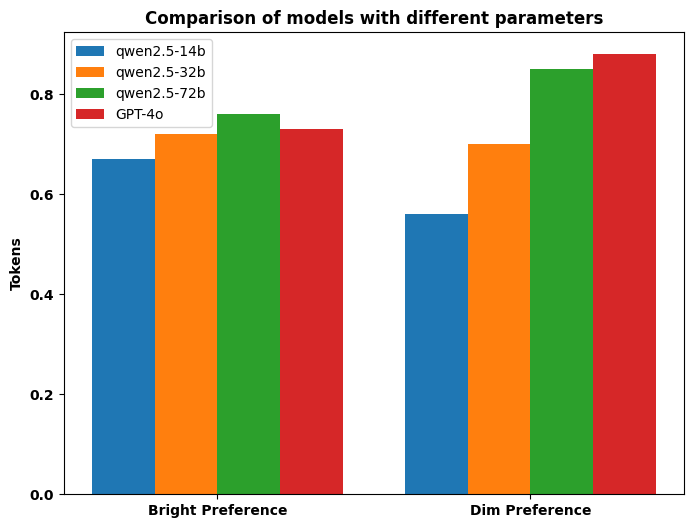

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for accuracy of 5 methods across 3 rounds
methods = ['qwen2.5-14b', 'qwen2.5-32b', 'qwen2.5-72b','GPT-4o']
rounds = ['Bright Preference', 'Dim Preference']
accuracy_data = {
    'qwen2.5-14b': [0.67, 0.56],
    'qwen2.5-32b': [0.72, 0.70],
    'qwen2.5-72b': [0.76, 0.85],
    'GPT-4o': [0.73, 0.88]
}

# Number of methods
num_methods = len(methods)
bar_width = 0.2  # Width of the bars
index = np.arange(len(rounds))  # X locations for each round

# Plotting
plt.figure(figsize=(8, 6))
for i, (method, accuracies) in enumerate(accuracy_data.items()):
    plt.bar(index + i * bar_width, accuracies, bar_width, label=method)

# Labels and titles
# plt.xlabel('Token consumption of each round')
#bold the x and y labels
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylabel('Tokens', fontweight='bold')
plt.title('Comparison of models with different parameters', fontweight='bold')
plt.xticks(index + bar_width * (num_methods - 1) / 2, rounds)
plt.xticks(fontweight='bold')
plt.legend()
plt.savefig('14b32b72b.pdf')
plt.show()
